# Neural Network

## 1 - Packages ##

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

## 2 - Overview of the Problem set ##

**Problem Statement**: 
We'll use the MNIST data set, which contains tens of thousands of scanned images of handwritten digits, together with their correct classifications. MNIST's name comes from the fact that it is a modified subset of two data sets collected by NIST, the United States' National Institute of Standards and Technology.

The MNIST dataset contains 60,000 images. These images are scanned handwriting samples from 250 people, half of whom were US Census Bureau employees, and half of whom were high school students. The images are greyscale and 28 by 28 pixels in size. 
So, you are given a dataset  containing:
    - a training set of m_train examples labeld as 0-9
    - a test set of m_test examples labeld as 0-9
    - each example is an array of length 784 (28 * 28) which represents image of handwritten digit.
    
You will build an algorithm that can recognize handwritten digits.

Let's get more familiar with the dataset. Load the data by running the following code.

In [0]:
# Read the MNIST dataset from ubyte files 

def read_mnist(images_path, labels_path):
    import struct
    import os
    with open(labels_path, 'rb') as p:
        magic, n = struct.unpack('>II', p.read(8))
        labels = np.fromfile(p, dtype=np.uint8)
    with open(images_path, 'rb') as p:
        magic, num, rows, cols = struct.unpack(">IIII", p.read(16))
        images = np.fromfile(p, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

# Shuffle dataset

def shuffle_data(features, labels, random_seed=42):
    assert len(features) == len(labels)

    if random_seed:
        np.random.seed(random_seed)
    idx = np.random.permutation(len(features))
    return [a[idx] for a in [features, labels]] 

# Loading data

def load_data():     
    X, y = read_mnist('samples/train-images-idx3-ubyte', 'samples/train-labels-idx1-ubyte')
    X, y = shuffle_data(X, y, random_seed=42)
    train_set_x, train_set_y = X[:5000], y[:5000]
    test_set_x, test_set_y = X[5000:], y[5000:]
    
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T
    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))
    
    return train_set_x, test_set_x, train_set_y, test_set_y

Let's create train and test datasets:

In [0]:
train_set_x, test_set_x, train_set_y, test_set_y = load_data()
print('train set shapes: ', train_set_x.shape, train_set_y.shape)
print('test set shapes: ', test_set_x.shape, test_set_y.shape)

train set shapes:  (784, 5000) (1, 5000)
test set shapes:  (784, 55000) (1, 55000)


### Data exploration ###

Let's build a function to check how the data looks like:

In [0]:
def plot_digit(x_set, y_set, idx):
    img = x_set.T[idx].reshape(28,28)
    plt.imshow(img, cmap='Greys',  interpolation='nearest')
    plt.title('true label: %d' % y_set.T[idx])
    plt.show()

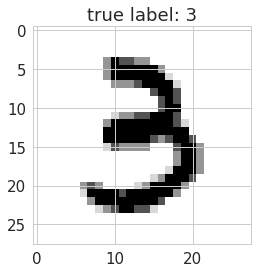

In [0]:
plot_digit(train_set_x, train_set_y, idx=1)

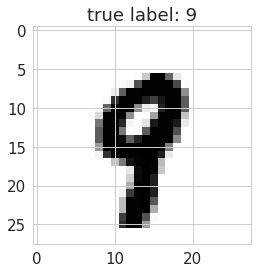

In [0]:
plot_digit(train_set_x, train_set_y, idx=3)

## 3 - Helper Functions

For begining we need to implement some special functions.

### Sigmoid (and it's derivative)

Any layer of a neural network can be considered as an Affine Transformation followed by application of a non linear function. A vector is received as input and is multiplied with a matrix to produce an output , to which a bias vector may be added before passing the result through an activation function such as sigmoid.

$$Input = x \quad Output = f(Wx+b)\tag{1}$$

The sigmoid function is used quite commonly in the realm of deep learning, at least it was until recently. It has distinct **S** shape and it is a differentiable real function for any real input value. Additionally, it has a positive derivative at each point. More importantly, we will use it as an activation function for the hidden layer of our model. Here's how it is defined:

$$\sigma (x) = \frac{1}{1+e^{-x}}\tag{2}$$

Here is first derivative (which we will use during the backpropagation step of our training algorithm). It has the following formula:

$$\frac{d\sigma (x)}{d(x)} = \sigma (x)\cdot (1-\sigma(x))\tag{3}$$

In [0]:
class Sigmoid:
    def __call__(self, z):
        return 1/(1+np.exp(-z))
    
    def prime(self, z):
        s = self.__call__(z)
        return s*(1-s)

In [0]:
x = np.linspace(-10., 10., num=100)
sig = Sigmoid()(x)
sig_prime = Sigmoid().prime(x)
print('sigmoid:')
print(sig[:5])
print('sigmoid_prime: ')
print(sig_prime[:5])

sigmoid:
[4.53978687e-05 5.55606489e-05 6.79983174e-05 8.32200197e-05
 1.01848815e-04]
sigmoid_prime: 
[4.53958077e-05 5.55575620e-05 6.79936937e-05 8.32130942e-05
 1.01838442e-04]


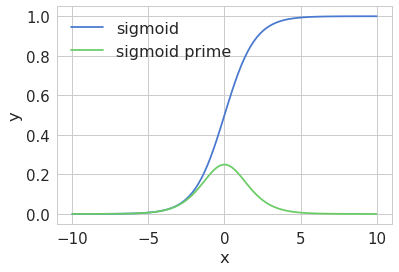

In [0]:
plt.plot(x, sig, label="sigmoid")
plt.plot(x, sig_prime, label="sigmoid prime")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(prop={'size' : 16})
plt.show()

### One-Hot ###

For convenience let's represent input labels $y$ as a 10-dimensional vector. For example, if a particular training image, $x$, depicts a 6, then $y(x)=(0,0,0,0,0,0,1,0,0,0)^T$ is the desired output from the network.

In [0]:
def one_hot(Y, n_classes):
    classes = np.arange(0,n_classes)
    return np.vectorize(lambda y:  np.where(classes == y,1,0), signature='()->(m)')(Y)[0].T

In [0]:
print('encoded:')
print(one_hot(np.asarray([1, 2, 3, 4, 3]).reshape(1, 5), 5))

encoded:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 1]
 [0 0 0 1 0]]


### Cost Function ###

Here is cost function for our model:
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)}\tag{4}$$
where 

$m$ - number of examples;

$n$ - number of classes;

$y$ - input labels;

$a$ - output of hidden layer.


We will use cross entropy loss:
$- \sum\limits_{i=0}^{m}  y^{(i)}\log(a^{[2](i)})\tag{5}$

In [0]:
def compute_cost(A2, Y):
    
    m = Y.shape[1] # number of examples
    cost = - np.sum(Y*(np.log(A2)) + (1-Y)*(np.log(1-A2))) / m
    
    return cost

In [0]:
np.random.seed(1)
print("cost:" + str(compute_cost(a_h, labels)))

cost:1.3770374288047718


### Regularization

In order to create less complex (parsimonious) model when you have a large number of features in your dataset, some of the Regularization techniques used to address over-fitting and feature selection are:

1. L1 Regularization

2. L2 Regularization

A regression model that uses L1 regularization technique is called Lasso Regression and model which uses L2 is called Ridge Regression.

Lasso Regression (Least Absolute Shrinkage and Selection Operator) adds “absolute value of magnitude” of coefficient as penalty term to the cost function.

Ridge regression adds “squared magnitude” of coefficient as penalty term to the loss function. 
The cost is then computed by summing squared diff over all training examples.
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \sum\limits_{j = 0}^{n}\large{(} \small y^{(i)}_{j}\log\left(a^{[2] (i)}_{j}\right) + (1-y^{(i)}_{j})\log\left(1- a^{[2] (i)}_{j}\right)  \small\large{)} + \frac{\lambda_1}{m}( ||w_1||_1 + ||w_2||_1) + \frac{\lambda_2}{2m} (||w_1||_2^2+||w_2||_2^2) \tag{6}$$

To calculate norms use "entrywise" norm.

In [0]:
class Regularization:
    def __init__(self, lambda_1, lambda_2):
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        
        
    def l1(self, W1, W2, m):

        norm = lambda W: np.linalg.norm(W, ord=1)
        return self.lambda_1 * (norm(W1) + norm(W2)) / m
        
    def l1_grad(self, W1, W2, m):
        
        return {
            "dW1": np.sign(W1)*self.lambda_1/m,
            "dW2": np.sign(W2)*self.lambda_1/m
        }

    def l2(self, W1, W2, m):
        
        norm = lambda W: np.linalg.norm(W)
        return self.lambda_2 * 0.5 * (norm(W1)**2 + norm(W2)**2) / m
        
    def l2_grad(self, W1, W2, m):
        
        return {
            "dW1": W1 * self.lambda_2/m ,
            "dW2": W2 * self.lambda_2/m
        }

In [0]:
reg = Regularization(0.3, 0.2)
print('l1 reg. term =', reg.l1(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l2 reg. term =', reg.l2(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l1 reg. gradient =', reg.l1_grad(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))
print('l2 reg. gradient =', reg.l2_grad(np.array([0.1, -0.2, 0.3, 0.4]), np.array([-0.5, 0.6, 0.7, 0.8]), 5))

l1 reg. term = 0.21600000000000003
l2 reg. term = 0.0408
l1 reg. gradient = {'dW1': array([ 0.06, -0.06,  0.06,  0.06]), 'dW2': array([-0.06,  0.06,  0.06,  0.06])}
l2 reg. gradient = {'dW1': array([ 0.004, -0.008,  0.012,  0.016]), 'dW2': array([-0.02 ,  0.024,  0.028,  0.032])}


## 3 - Neural Network. General Architecture ##

To recognize digits we will use a two-layer neural network. Here is model of our network:
    <img src="samples/arc.png" style="width:620px;height:500px;">
    
The input layer of the network contains neurons encoding the values of the input pixels. As discussed earlier, training data consist of many 28 by 28 pixel images of scanned handwritten digits, and so the input layer contains $784=28×28$ neurons. The input pixels are greyscale, with a value of 0.0 representing white, a value of 1.0 representing black, and in between values representing gradually darkening shades of grey.

The first layer of the network is a hidden layer. We denote the number of neurons in this hidden layer by n, and we'll experiment with different values for n. The example shown illustrates a small hidden layer, containing just $n=15$ neurons.

The output layer of the network contains 10 neurons. If the first neuron fires, i.e., has an output $≈1$, then that will indicate that the network thinks the digit is a 0. If the second neuron fires then that will indicate that the network thinks the digit is a 1, and so on. A little more precisely, we number the output neurons from 0 through 9, and figure out which neuron has the highest activation value. If that neuron is, say, neuron number 6, then our network will guess that the input digit was a 6. And so on for the other output neurons.

Each training input $x$ is a $28×28=784$-dimensional vector. Each entry in the vector represents the grey value for a single pixel in the image. 


### 3.1 - Neural Network Class ####

In this block we will implement class *NeuralNetwork*, which will perform forward and backward propagation, and update parameters.  

**Main steps to build neural network:**
    1. Initialize the model's parameters
    2. Loop:
        - Implement forward propagation
        - Compute loss
        - Implement backward propagation to get the gradients
        - Update parameters (gradient descent)
        
**1. Initializing the model's parameters**

You need to do following steps:
- Make sure your parameters' sizes are right. Refer to the neural network figure above if needed.        
- Initialize the weights matrices with random values from the “standard normal” distribution, where sigma = 0.01, mu = 0. 
- Initialize the bias vectors as zeros. 
   
**2. Loop**

   - *Forward propagation*
   
In forward propagation we use the data and the weights of the network to compute a prediction, so during this step we just multiply the matrix containing our training data with the matrix of the weights of the hidden layer.

For one example $x^{(i)}$:
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}\tag{8}$$ 
$$a^{[1] (i)} = \sigma(z^{[1] (i)})\tag{9}$$
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}\tag{10}$$
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})\tag{11}$$
$$y^{(i)}_{prediction} = argmax(a^{[2](i)}) \tag{12}$$

Definition: 

$W^{[1]}$: weights matrix 1

$W^{[2]}$: weights matrix 2

$b^{[1]}$: bias 1

$b^{[2]}$: bias 2

$z^{[1] (i)}$ : input of the hidden layer

$a^{[1] (i)}$: activation of the hidden layer

$z^{[2] (i)}$: input of the output layer 

$a^{[2] (i)}$: activation of the output layer

$\hat{y}^{(i)}$: array of predictions

   - *Backward propagation*
   
In backpropagation step we apply the activation function (sigmoid) to the result and multiply that with the weight matrix of the output layer. 

<table style="width:80%">
    <tr>
       <td> $dz^{[2]} = a^{[2]} - y$  </td>
       <td> $dZ^{[2]} = A^{[2]} - Y$ </td>
    </tr>
    <tr>
       <td> $dW^{[2]} = dz^{[2]}a^{[1]T} + \frac{\lambda_1}{m}sign(W^{[2]}) + \frac{\lambda_2}{m}W^{[2]}$ </td>
       <td>  $dW^{[2]} = \frac{1}{m}dZ^{[2]}A^{[1]T} + \frac{\lambda_1}{m}sign(W^{[2]}) + \frac{\lambda_2}{m}W^{[2]}$ </td
       
    </tr>
    <tr>
       <td> $db^{[2]} = dz^{[2]}$ </td>
       <td> $db^{[2]} = \frac{1}{m}np.sum(dZ^{[2]}, axis=1, keepdims=True)$ </td>
    </tr>
    <tr>
       <td> $dz^{[1]} = W^{[2]T}dz^{[2]}*\sigma'(z^{[1]})$ </td>
       <td> $dZ^{[1]} = W^{[2]T}dZ^{[2]}*\sigma'(Z^{[1]})$ </td>
    </tr>
    <tr>
       <td> $dW^{[1]} = dz^{[1]}x^T + \frac{\lambda_1}{m}sign(W^{[1]}) + \frac{\lambda_2}{m}W^{[1]}$ </td>
       <td> $dW^{[1]} = \frac{1}{m}dz^{[1]}X^T + \frac{\lambda_1}{m}sign(W^{[1]}) + \frac{\lambda_2}{m}W^{[1]}$  </td>
    </tr>
    <tr>
       <td> $db^{[1]} = dz^{[1]}$ </td>
       <td> $db^{[1]} = \frac{1}{m}np.sum(dZ^{[1]}, axis=1, keepdims=True)$  </td>
    </tr>
</table>

   - *Update Parameters*
   
Next, the error is computed based on the prediction and the provided labels. The final step propagates the error through the network, starting from the final layer. Thus, the weights get updated based on the error, little by little. To implement this method we will use gradient descent. You have to use (dW1, db1, dW2, db2) in order to update (W1, b1, W2, b2).

**General gradient descent rule**: $ \theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$ where $\alpha$ is the learning rate and $\theta$ represents a parameter.

**Illustration**: The gradient descent algorithm with a good learning rate (converging) and a bad learning rate (diverging). Images courtesy of Adam Harley.

<img src="samples/sgd.gif" style="width:400;height:400;"> <img src="samples/sgd_bad.gif" style="width:400;height:400;">


In [0]:
class NeuralNetwork:

    def __init__(self, n_features, n_hidden_units, n_classes , learning_rate, reg=Regularization(0.1, 0.2), sigm=Sigmoid()):
        self.n_features = n_features
        self.n_classes = n_classes
        self.learning_rate = learning_rate
        self.n_hidden_units = n_hidden_units
        self.reg = reg
        self.sigm = sigm
        self.W1 = None
        self.b1 = None
        self.W2 = None
        self.b2 = None
        
        self.initialize_parameters()

    def initialize_parameters(self):
        np.random.seed(42) 
    
        self.W1 = np.random.normal(loc=0.0,scale=0.01, size=(self.n_hidden_units, self.n_features))
        self.W2 = np.random.normal(loc=0.0,scale=0.01, size=(self.n_classes, self.n_hidden_units))
        self.b1 = np.zeros((self.n_hidden_units, 1))
        self.b2 = np.zeros((self.n_classes, 1))

    def forward_propagation(self, X):
        
        Z1 = self.W1.dot(X)
        A1 = self.sigm(Z1)
        Z2 = self.W2.dot(A1)
        A2 = self.sigm(Z2)

        return {
            'Z1': Z1,
            'A1': A1,
            'Z2': Z2,
            'A2': A2
        }
    
    def backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        
        A2 = cache["A2"]
        A1 = cache["A1"]
        L1, L2 = self.reg.l1_grad(self.W1, self.W2, m), self.reg.l2_grad(self.W1, self.W2, m)

        dZ2 = A2 - Y
        dW2 = dZ2.dot(A1.T) / m  + L1["dW2"] + L2["dW2"]
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m
        
        dZ1 = self.W2.T.dot(dZ2)*(self.sigm.prime(cache["Z1"]))
        dW1 = dZ1.dot(X.T) / m + L1["dW1"] + L2["dW1"]
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m 

        return {
            'dW1': dW1,
            'db1': db1,
            'dW2': dW2,
            'db2': db2
        }

    def update_parameters(self, grads):

        self.W2 -= self.learning_rate*grads["dW2"] 
        self.W1 -= self.learning_rate*grads["dW1"] 
        self.b2 -= self.learning_rate*grads["db2"] 
        self.b1 -= self.learning_rate*grads["db1"] 

### 3.2 - Model ####

Now we can aggregate all previous modules into a classifier:

In [0]:
class NNClassifier:
    
    def __init__(self, model, epochs=1000):
        self.model = model
        self.epochs = epochs
        self._cost = [] # Write value of cost function after each epoch to build graph later
    
    def fit(self, X, Y):
    
        self.model.initialize_parameters()
        Y_one_hot = one_hot(Y, len(np.unique(Y)))
        
        for _ in range(self.epochs):
            output = self.model.forward_propagation(X)
            self._cost.append(compute_cost(output["A2"], Y_one_hot))
            grads = self.model.backward_propagation(X, Y_one_hot, output)
            self.model.update_parameters(grads)
    
    
    def predict(self, X):
        cache = self.model.forward_propagation(X)
        return np.argmax(cache['A2'], axis=0).T

In [0]:
def accuracy(pred, labels):
    return (np.sum(pred == labels, axis=1) / float(labels.shape[1]))[0]

In [0]:
def plot_error(model, epochs):
    plt.plot(range(len(model._cost)), model._cost)
    plt.ylim([0, epochs])
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.show()

## 4 - Training 

In [0]:
NN = NeuralNetwork(784, 30, 10, 0.01)
classifier = NNClassifier(NN, 5000)

In [0]:
classifier.fit(train_set_x, train_set_y)

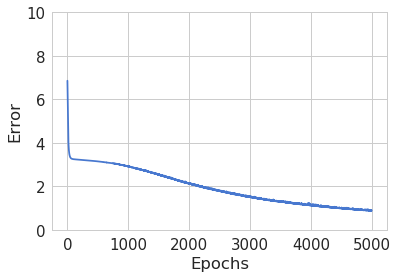

In [0]:
plot_error(classifier, 10)

## 5 - Making predictions

In [0]:
pred_train = classifier.predict(train_set_x)
pred_test = classifier.predict(test_set_x)

print('train set accuracy: ', accuracy(pred_train, train_set_y))
print('test set accuracy: ', accuracy(pred_test, test_set_y))

train set accuracy:  0.9468
test set accuracy:  0.8661272727272727


Now we can check our classifier on single example:

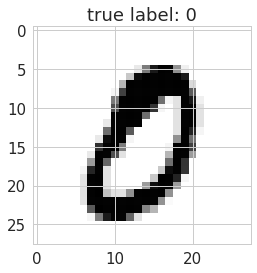

In [0]:
plot_digit(test_set_x, test_set_y, idx=6)

In [0]:
pred_single = classifier.predict(test_set_x.T[6].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 0


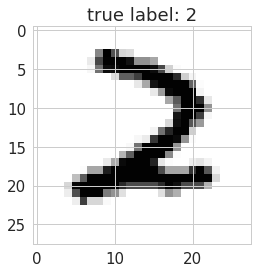

In [0]:
plot_digit(test_set_x, test_set_y, idx=90)

In [0]:
pred_single = classifier.predict(test_set_x.T[90].reshape(784, 1))
print("The digit is " + str(pred_single[0]))

The digit is 2
